# Lab 3: Building a Photometric Pipeline

In this lab, we'll be using classes and functions to build a pipeline which will automatically extract the fluxes of stars in an image. We're all familiar with aperture photometry, but in this case, we're going to take the additional step of convolving our image with a PSF. 

Our pipeline will be split into several steps. 

1. Reading in an image 
2. Finding the local peaks in the image (the stars)
3. Calculating the centroid of each peak region 
4. Convolving with the PSF and extracting flux. 



```{warning}
When you modify a class and re-run it, you need to re-instantiate (or make a new instance) of the class for it to reflect the changes. This is a common mistake in notebooks, where a class might get changed but your instance of it didn't get re-created. Watch out for this during the lab -- the safest bet is to just copy-paste your instantiation code (`a = MyObj()` type thing) into each problem so you sure you're working with the latest version of your class. 

You'll be copying and pasting (and overwriting) your class in this assignment quite a bit. That's not super realistic to reality (where you'd pick one cell and keep modifying it there), but for grading purposes we ask you follow along so we can give credit for each method of the class you complete and demonstrate along the way.
```

## Assignment Rubric
````{panels}
The points for this assignment are as follows:
- Problem 1 (4 pts)
- Problem 2 (8 pts)
- Problem 3 (5 pts)
- Problem 4 (3 pts)
````

## Problem 1
In this problem, we'll load in the image(s) for use and begin constructing our `PSFPhot` class. 

### Problem 1.1
Create a script (`.py` file) in this directory and copy into it your `load_fits()` and final `implot()` functions from last lab. Then import them here. 

Use your `load_fits()` to read in in the image `2020-04-15-0001.fits` and plot it with `implot()`. 

This image was taken of the M81/M82 field using the Dragonfly Telephoto Array (in a narrowband configuration). 

In [ ]:
# import your functions here 

In [1]:
# Use them to load and show the image we'll be working with

```{hint}
M82 should be visible left of center, M81 on the left hand edge. Two features caused by detector amp glow are also visible at the bottom of the image. 
```

### Problem 1.2 

Finish the syntax for creating the `PSFPhot` class below. The init for the class should ask for three string paths: one to an image, one to a dark file, and one to a flat file. Within `__init__()`, use your `load_fits()` function to get the just the science image and header into the class. Store them as class attributes `self.data_init` and `self.data_header`.

Don't forget to add a docstring to your init! It doesn't return anything, but sets the initial attributes.

In [ ]:
class PSFPhot():
   

### Problem 1.3 

Add a method to your class called `dark_subtract()` which takes an image and a string-path to a dark file. Use `load_fits()` to read it in the dark, and subtract it from the image, and return the output. 

Add another method called `flat_field()` which takes in an image and a string-path to a flatfield file. Use `load_fits()` to read it in, normalize it to its maximum value, and divide the input image by it. 

Finally, within your init function, set a new class attribute called `self.data_calibrated`, and set it equal to the output of your calibration methods as run on the set of image paths that have been input. 

```{hint}
This step can be done in one line with nested functions if you prefer.
``

Finally Use `implot()` to plot both the `data_init` and `data_calibrated` and show that your calibrations worked. You should see the amp glow regions dissapear, and the image sky should look nice and uniform.

In [527]:
class PSFPhot():
    

```{note}
Running the dark/flat methods within init means they'll happen right away when someone instantiates an object of this class. It's a matter of code design and personal preference to do this, versus having the user run those methods manually as part of the UX. I choose to wrap it into the init because it's a basic, common thing all inputs will need done to them.
```

### Problem 1.4 

The final step in setting up our image for proper analysis is the subtraction of the globally varying sky background. Performing that fit (generally a low order 2D polynomial of some kind) is beyond the scope of this lab, but we encourage you to look into this step more if you are interested. 

Instead, we're going to return to the `sep` package and take advantage of its background estimation feature. Recall it reads in the base image array and a separate mask. We want the user of this class to be able to supply a mask, so we won't run this step automatically in `__init__()`.

Using the same stucture as in Lab 2, we'll calculate the background using `sep`.

Add a method to your class that is called `subtract_background`, whose only argument (besides `self`) should be an optional mask (default `None`). 

Inside, use `sep` to measure the background and access, e.g., the `bkg.back()` method, and subtract this background-image from `self.data_calibrated`. You should set `mask=mask` in the sep call so your method input gets passed through. For convenient access, store the output of `bkg.back()` in a class attribute called `self.background`, and then set `self.image` equal to the background subtracted image. This method is known as a *setter*, because we're setting a class attribute but not returning anything. 

It can be handy here to add a print statement at the end of the method saying something like `"Background estimated; output saved to attribute 'image' "`. Since this is the main image we'll be using from now on, I've elected to give it the short name `image`. You may rather use something like `data_bg_sub`, for example

```{warning}
Don't forget about the C order switch with sep.
```

In [528]:
class PSFPhot():
    
    

Our class usage will now look something like 
```
pipe = PSFPhot(im_path,dark_path,flat_path)
pipe.subtract_background()
```

or, if we create a mask (as we will below), 
```
pipe = PSFPhot(im_path,dark_path,flat_path)
mask = # Something here 
pipe.subtract_background(mask=mask)
```


## Problem 2

Our goal is to estimate the PSF of the above image, then measure fluxes of the stars and galaxies here accounting for the PSF. 

To start this process, we need to locate the stars in this image. We saw how to segment an image using `sep` last time, but in this lab we are going to carry out this step ourselves, using two methods. 

### Problem 2.1

Before we do this, we want to take the step of masking out several regions of the image which may register as peaks but which are not nicely isolated stars. In particular, the two galaxies need to be masked out when both estimating the background and when looking for point sources.


Create a mask of the dimensions of the image data, containing `False` everywhere except where we want to mask out the galaxies (rough rectangular regions are fine for this masking). It's easiest to make the full array `False` first, then set the regions we want to mask to `True` via image indexing. 

Add a method to your class called `set_image_mask()` which overwrites `self.image` with a numpy masked array containing what used to be `self.image` as the data, and a mask that the user inputs. 

Finally, instantiate your class into a variable and check that the masking and subtraction are both working. You should plot your image by accessing it (it should be a class attribute by now). It should look like mine below.
```{warning}
If we have the memory to, it's often worth avoiding overwriting class attributes. Here, we could set the masked image as `self.image_masked`, for example. I've elected not to here for two reasons. One: simplicity. Two: the unmasked version of the image is easily accessible still via `self.image.data`, the data attribute of numpy masked arrays.
```

In [535]:
# Solution
mask = #define mask 

class PSFPhot():
    

Background estimated; output saved to attribute image


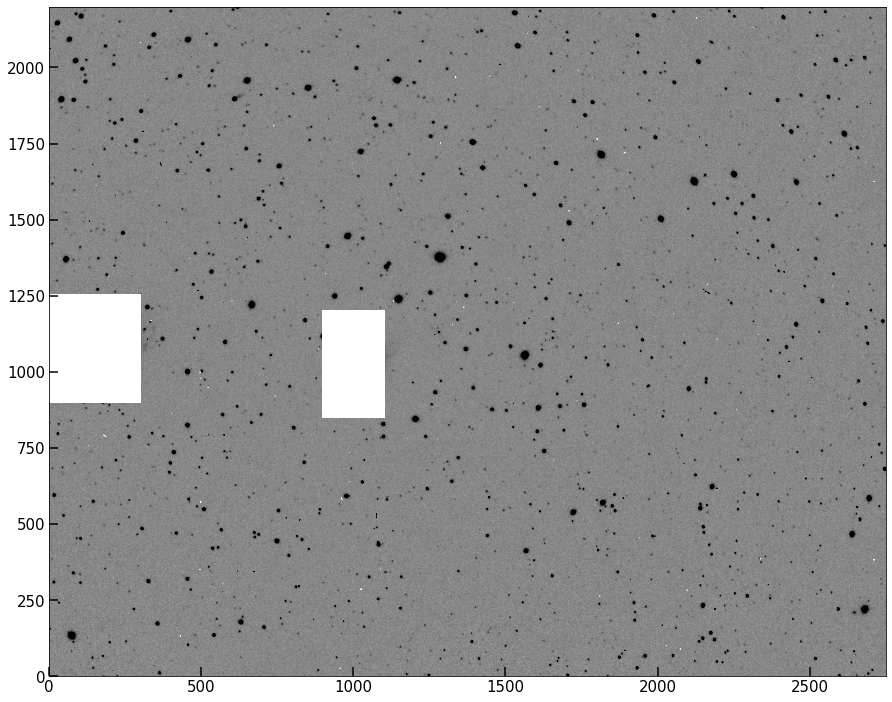

In [536]:
# instantiate your class, run the subtraction, input the mask, see that it all works.


```{note}
In our use case for this lab, the mask we will use when background subtracting is the same as the one we'll use for blocking out regions from being included in peak finding and such. But our code is flexible enough to, e.g., mask when background-subtracting but not when peak finding, or vice versa. Our mask setter only affects the image data, and the mask argument in the subtract background method only affects background subtraction.
```

```{tip}
As it stands, `set_image_mask()` can only be run *after* `subtract_background()`, because that method sets `self.image` for the first time. We can use the `hasattr(self,'image')` check to see, when `set_image_mask()` is run, if that previous method was already run and `self.image` exists. For now, it's ok to assume the user will use the class in order, but a more robust code would either raise an exception or otherwise handle this case in some way.
```

Plot the `.background` attribute of your class. It seems our image has a spatially varying background that includes a gradient across the image.

In [ ]:
#plot the background

### Problem 2.2

Now that we have the appropriate image regions masked, we can move on to the peak finder. 

The "fast" or "efficient" method of doing this involves some scipy filtering operations. But for our purposes, the "slow way" (iterating over the image pixels) takes ~few seconds to run, and is worth doing to build intuition. 

Add a method to your class to find peaks in an image by looping over each pixel and checking its neighbors, with a "peak" being defined as a region of higher flux than all adjacent pixels (i.e., the 8 surrounding pixels). In order to not pick up random noise pixels, also take an input called `threshold`. Within your algorithm, don't return any pixels which are "peaks" but for which the pixel value is below this threshold. 

```{hint}
:class: dropdown
This algorithm needs to avoid the edges of the image (since indexing "i+1" won't work there). Creating a 1 pixel "buffer" in your looping will prevent this. 
```

In [70]:
# your code here

The looping solution is slow, and will not scale well if we have to run on many images, but for one image is okay. 

There are several solutions which generally involve either **filtering** the image or **cross correlating** the image with a template. Here's one such solution.

In [399]:
from scipy.ndimage import maximum_filter

def findpeaks_maxfilter(image, threshold):
    '''
    Algorithm for finding peaks (above a threshold) in an image
    
    Parameters
    ----------
    image: array_like
        2D array containing the image of interest.
    threshold: float
        minimum pixel value for inclusion in search
    
    Returns
    -------
    peaks: array_like
        array containing the x and y coordinates of peak regions.
    '''
    neighborhood = np.ones((3,3),dtype=bool) # just 3x3 True, defining the neighborhood over which to filter
    # find local maximum for each pixel
    amax = maximum_filter(image, footprint=neighborhood) #max filter will set each 9-square region in the image to the max in that region.
    
    peaks = np.where((image == amax) & (image >= threshold)) #find the pixels unaffected by the max filter.
    peaks = np.array([peaks[0],peaks[1]]).T
    return peaks

Let's take a moment to understand how this algorithm works. The key is in the `maximum_filter()` step. Filtering a 2D image is a process carried out in fourier space, which is what allows scipy to carry it out quickly. But what is maximum filtering?

```{admonition} Definition
Maximum Filtering is the process by which all pixels in local neighborhoods within an array are raised to the maximum value of any pixel in that neighborhood
```

Let's look at a 1D case. Below, I define a 1D array that has some peaks in it. 

In [110]:
array_1dpeaks = np.array([1,1,2,1,2,1,2,1,2,3,4,3,2,1,2,4,5,6,8,6,5,4,3,2,4,3,4,2,1,0.5,1,2,1,2,3,2])

Our data looks like this:

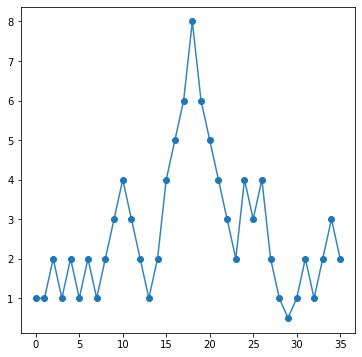

In [122]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(array_1dpeaks,lw=1.5,alpha=0.9)
ax.plot(array_1dpeaks,'o',color='C0')

Let's now run the maximum filter on this data and plot it's output. I'm going to pick a neighborhood of 3, which means +/- 1 pixel around each location.

In [112]:
mf = maximum_filter(array_1dpeaks, footprint=np.ones(3,dtype=bool)) 

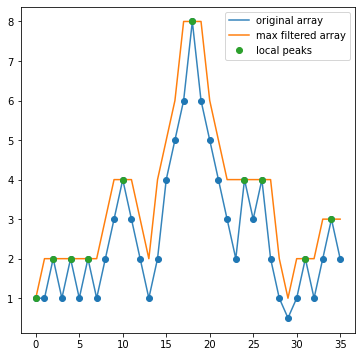

In [120]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(array_1dpeaks,lw=1.5,alpha=0.9,label='original array')
ax.plot(array_1dpeaks,'o',color='C0')
ax.plot(mf,label='max filtered array')
eq, = np.where(array_1dpeaks==mf)
ax.plot(np.arange(len(mf))[eq],mf[eq],'o',label='local peaks')
ax.legend();

What the filtering has done is for every 3 pixel neighborhood across this array, it's raised the value of all three pixels to the maximum value across the three. So we see that anywhere the three pixels were, e.g., (1,2,1), they are all now 2. What you should notice looking at this plot is that the max filtering has also identified true peaks in our data! Notice that the only spots where the orange curve (the max filtered version of the data) is equal to the original array is exactly at locations that are local maxima. This is because when applying max filtering to an array, the only values *unchanged* by the filtering are those that *are* local maxima (in the neighborhood defined). 

And thus, we have our peaks! All we need to do is find out `where()` the max filtered array equals the original array. Of course, we can also put in a threshold (in this example, maybe 2.5) to ensure low level noise doesn't enter in. This is why the `findpeaks_maxfilter()` function has a threshold option as well.

```{note}
You may notice that the first index in the array is marked as a peak, despite not being one. Edges are always troublesome with these algorithms, and they normally have multiple options for how edges are handled, e.g, interpolating a constant value, reflecting over the edge, etc. For our lab, we're not going to worry about this.
```


### Problem 2.3 

How fast is max filtering over your looping algorithm?

Use the `%%timeit` magic command in your notebook to test how fast the two algorithms are respectively. If you were working with a sample of 1000 images, how long would the looping algorithm take compared to the max-filtering case?

```{hint}
Check out the "Timing Code" page in the "Quick Tips" sidebar tab of our website to see examples of using the `timeit` module.
```

In [ ]:
# time your function

In [ ]:
# time the max filter function

How many times faster is the max filtering?

In [ ]:
# Calculate 

How long would it take to run each on 1000 images (extrapolating from your results)?

In [ ]:
# Calculate

For the rest of the lab, you can either leave in your peak finder, or replace it with the max-filtering version (turning the function above into a method). 

Either way, add a peak-finding method into your class, which should be runnable with no inputs, but has an optional threshold argument to set a minimum flux value for inclusion.    

In [ ]:
# your class here

### Problem 2.4 

Run your peakfinder on your masked image, and assemble the list of peaks you'll use moving forward. Your peakfinder method should save a class attribute `self.peak_locations` which contains the ($x,y$) pairs of points associated with your peaks. 


Plot up the original image, but use our "source circling" technique from last lab to circle all the peaks found in the masked image. I show mine below. 

```{hint}
Recall that `implot()` returns a set of `fig, ax`, so you can then plot the circles onto the same axis as the image.
```

Background estimated; output saved to attribute image


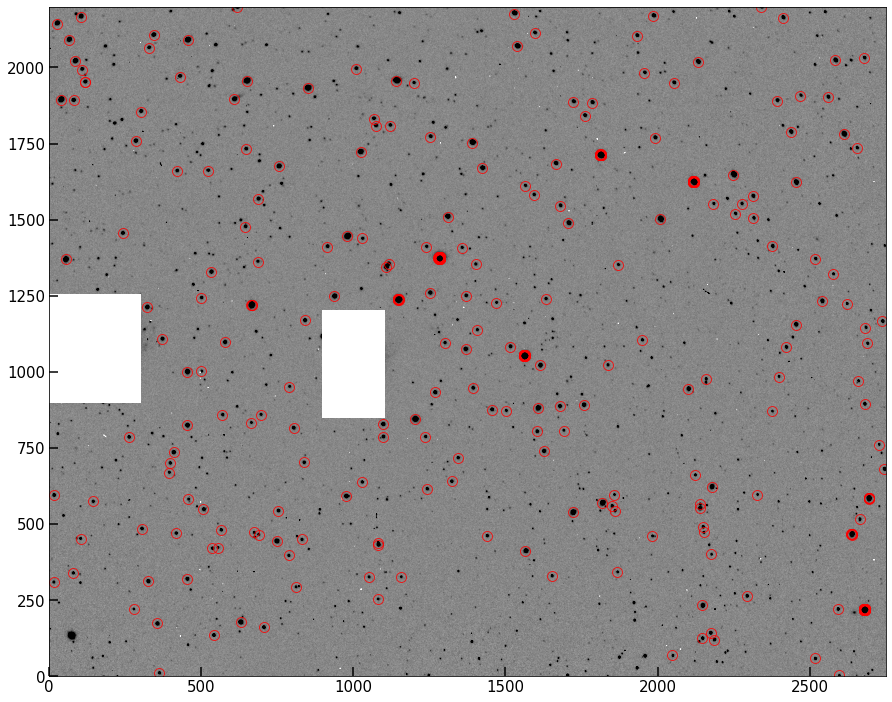

In [549]:
# re-instantiate your object, run the subtraction, then your new peak finder here. 

### Problem 2.5 

This should look pretty good -- most of what's circled above is clearly a star/point source in the image. However, one problem with this method is that single hot pixels are going to be registered as peaks, even via the clever algorithm. We need a way to eliminate these from our sample before moving on. 

Adjust your peak-finder method to add in something that checks that not only is there a true peak, but that at least 4 of the pixels around the peak are also elevated in flux (I used 0.5 times the peak flux). The easiest way is to loop over the peaks after they're found and institute the check --- there are far fewer peaks than pixels, so this doesn't significantly affect the runtime. But feel free to find a cleverer solution!

```{warning}
Be careful with transpositions in this problem. when you plot coordinates, you plot(x,y), but when you index the image, you index image[y,x]. Always be tracking which is which! 
```

In [619]:
class PSFPhot():
    

Re-find your peaks using your newer, better algorithm, and plot them below as before.

In [ ]:
# your code here

Notice that we've decreased our total number of peaks. But you should find that now, everything currently circled looks like a bright, "resolved" star. (resolved insofar as the PSF is spreading the light of the star over multiple pixels). 

### Problem 2.6 

In your the image above, you should see that ~8-10 stars look like they are circled by several very closely overlapping circles all targeting the same star. Infer (or investigate and determine) why this has happened, and write your answer below. 




*answer here*

## Problem 3 

We now have a function that can return the peaks in a given image. Our next step is going to be to estimate the exact center of those peaks (stars) using their **centroid**.

```{admonition} Definition
The centroid is the light-weighted-mean of a set of pixels. It is not always the maximum-valued pixel, and is determined to sub-pixel accuracy.
```

Many of you have seen the centroid formula, but as a reminder, it looks like this (in 1D):


$$
x_{\rm com} = \frac{\sum{x_i \hat{f}_i}}{\sum \hat{f}_i},
$$

where $x_i$ are the positions and $\hat{f}_i$ are the fluxes at those positions. 

In 2D, when working with images, the $x$ and $y$ centers of mass are independent, and the 2D centroid is just the location ($x_{\rm com}$, $y_{\rm com}$). 

### Problem 3.1 

Add a method to your class called `centroid()` which should read in an $x$ and $y$ peak location (these will be returned by your peak finder), then creates a cutout by indexing `self.image` in a window of N (user-settable), and determine the centroid of this window. The $x,y$ location of this centroid should be returned.

One subtlety --- We want to use a window size greater than 1 pixel on either side of each peak. But because our peak finder is likely to have found peaks near the edge of the detector (both because it needs only 1 pixel-thick borders and because it handles edges), if we write a centroid function that, e.g., uses a 10x10 pixel window, we'll end up trying to index over the edge of the original image whenever there's a star near the edge. Because of this, your function should raise an exception if a peak position is entered whose distance from an edge is less than half the window size. 

In [622]:
class PSFPhot():
    # copy down and add to your class

### Problem 3.2 
Use your `centroid()` function to confirm that the algorithm is working by testing it on a few individual peaks from your peak list, and make a plot showing the window region and the determined centroid (along with the location of the input peak). I'm leaving behind a demo of what I mean below. The blue point is the pixel with the peak flux, while the crosshairs center on the determined centroid

```{Note}
It's usually ok if the centroid is not at what appears to be the very center of the light distribution of the star. Often due to seeing and detector effects, along with tricks of the stretch you happen to be using, the centroid doesn't look perfectly centered. But it shouldn't be super off, either -- see below.
```
In my solution below, I plot 25 stars from my peak finder, with peaks and centroids shown. You should get similar looking results as you query stars in frame.


Background estimated; output saved to attribute image


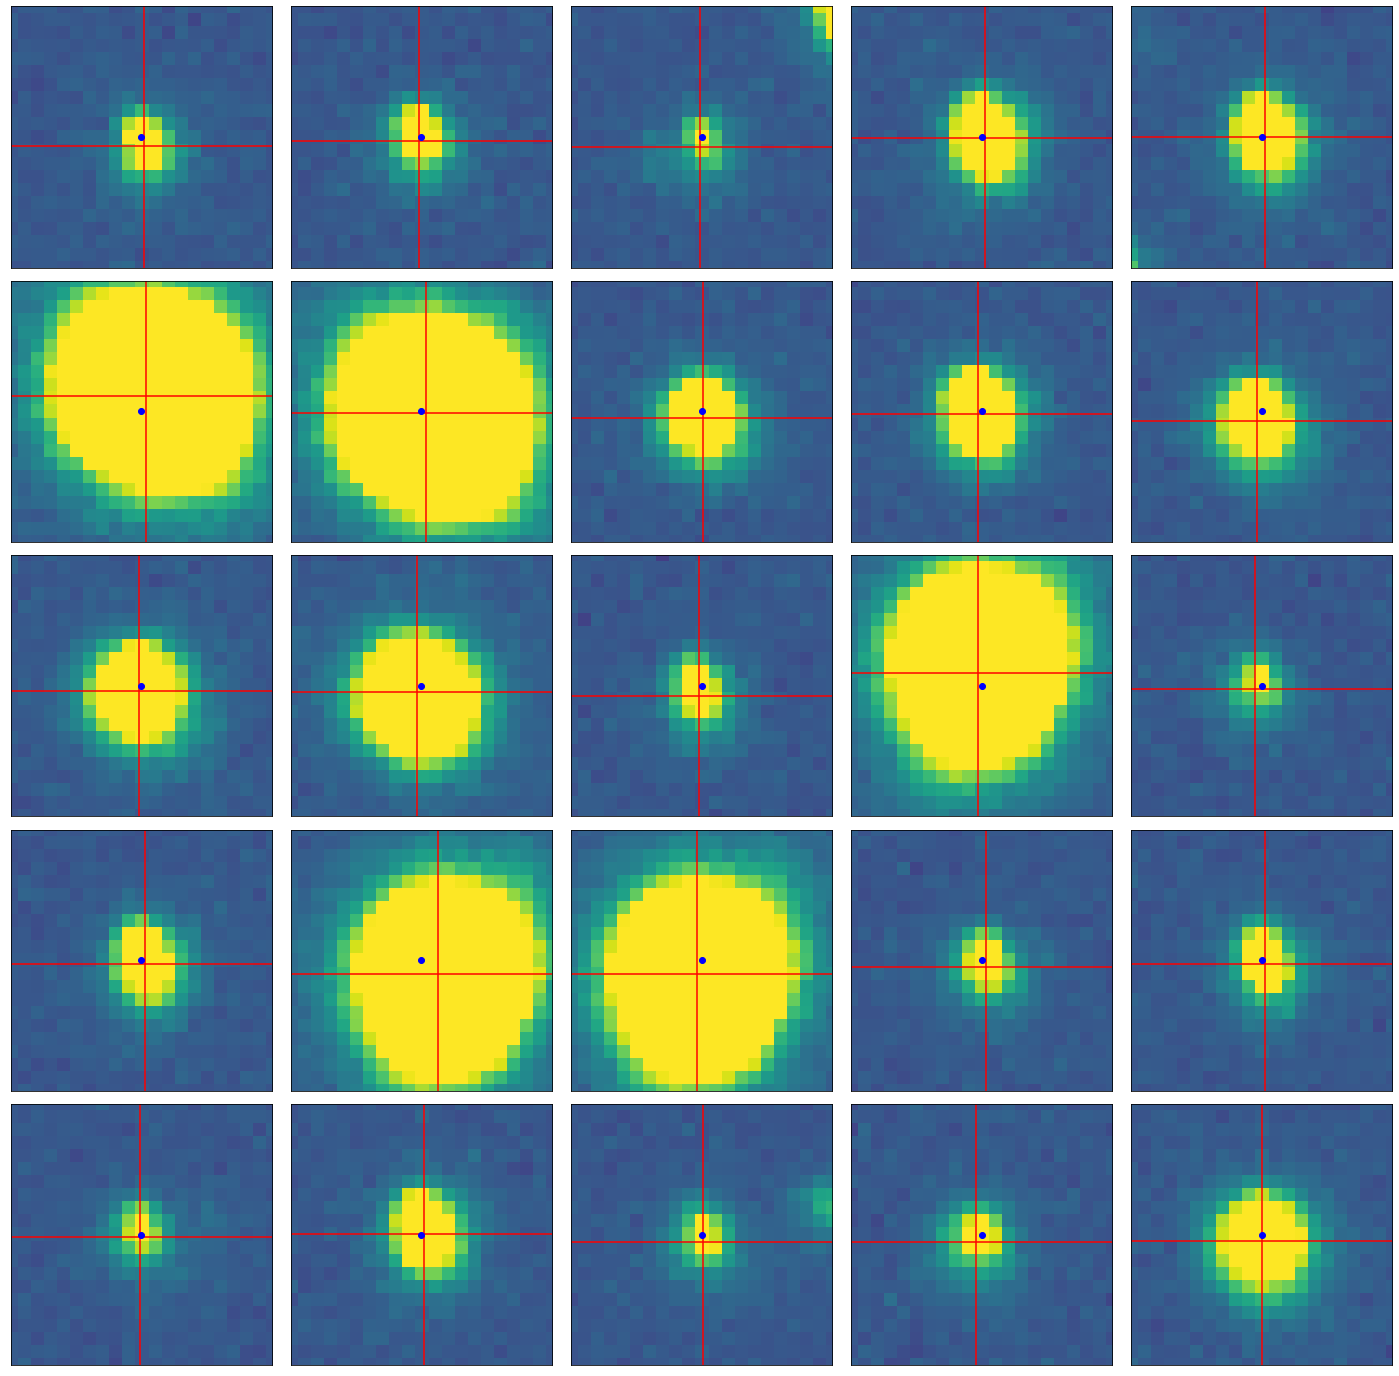

In [624]:
# You need not plot 25, but check a handful of stars to make sure you're in business.

### Problem 3.3 

If you recall from above, you determined why the peak algorithm occasionally marked a bunch of pixels as peaks within the same star, which shouldn't happen. It should be clear from your answer that these stars will be unusable for the purposes of measuring the PSF of stars in the image. We thus need to remove these ~8-10 stars from our sample. 

Write a method `check_stars()` which takes in the list of centroids, and identifies these cases. The easiest way to do this is to simply iterate through the list of centroids and compute the distance to all other centroids in the list. Any subgroups with small distances should be removed. (Say, 5-10 pixels). 


This method should return the final list of centroids for use. Plot them over the data to confirm these "stacked" peak cases have been removed.   


In [ ]:
# your code here

## Problem 4

Armed with a dark-subtracted, flat-fielded, background-subtracted image, as well as with a list of centroids corresponding to stars in our image, we are ready to estimate the PSF. 

There are two main functional forms typically used to fit star profiles: 2D Gaussians, and Moffat profiles (which combines the shapes of a Gaussian and Lorentzian to best match both the inner and outer regions of the PSF). 

We're going to use the [`Gaussian2D`](https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Gaussian2D.html) class from `astropy` to do this:

In [433]:
from astropy.modeling.functional_models import Gaussian2D

For each star, a Gaussian2D profile (normalized) will be used "as the PSF". The parameters we need to know for this profile are $x,y$, for which we'll use the centroids we calculated earlier, the amplitude (set by the normalization), and $\sigma_x,\sigma_y$, the standard deviations in the two axes. For this lab, we're going to assume our stars are circular ($\sigma_x=\sigma_y$). This is a strictly incorrect, but not a bad assumption for most cases. All other optional arguments we won't need, primarily due to the assumption of circularity. 

```{note}
We are going to make a point estimate of the "size" of the stars in our image, which constrains us from using a more fancy model for the PSF. An example of a more sophisticated setup would be *fitting* a Gaussian or Moffat profile to every star, and in a Bayesian framework marginalizing over the stars to determine the best-fit PSF (including ellipticity, etc) for the image, or, even fancier, interpolating a PSF model which varies over the detector.
```

PSF photometry works by multiplying the *data* (say, a cutout around a star) by the *estimated PSF* during the fluxing stage. Instead of picking a radius and performing aperture photometry (which includes fully all pixels within the aperture and throws out all pixels beyond), this method attempts to weight each pixel fractionally by how likely it is to be stellar flux, with the weighting coming from the PSF of the detector. This means further pixels may still be included, but will contribute less than pixels near the center of the star. 

The formula for measuring the PSF flux of a star is 

$$
f_{\rm PSF} = \frac{\sum \hat{f_i} p_i}{\sum p_i^2},
$$

where $\hat{f_i}$ are the fluxes in your image and $p_i$ is your PSF estimate. This formula should be reminiscent of the centroiding formula; it's a similar weighting scheme.

`Gaussian2D` is a class, but we want to interact with it pretty simply, and have simplified inputs. I've made a quick wrapper function below which allows us to enter $\sigma_x$ and $\sigma_y$ and then $x,y$ grids created via `np.meshgrid()`, and creates the Gaussian and evaluates it on our grid. 

In [490]:
def eval_gauss(x_arr,y_arr,sigma_x,sigma_y,mu_x,mu_y):
    
    g = Gaussian2D.evaluate(x=x_arr,y=y_arr,amplitude=1,theta=0,x_mean=mu_x,
                   y_mean=mu_y,
                   x_stddev=sigma_x,
                   y_stddev=sigma_y)
    g/=np.sum(g)
    return g

In [491]:
xx, yy = np.meshgrid(np.arange(loc[0]-10,loc[0]+10),
                     np.arange(loc[1]-10,loc[1]+10))
model = eval_gauss(x_arr=xx,y_arr=yy,sigma=3,mu_x=testx,mu_y=testy)

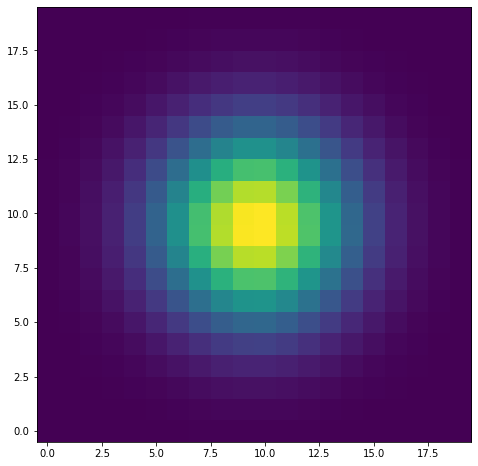

In [485]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(model,origin='lower')

As we can see, I now have a model for the PSF which I can easily create for given inputs. We're going to do this for cutouts around each star, and instead of a random $\sigma$, we're going to estimated it using the second moment (moment of inertia) of the star itself.

The formula for this (from Markevich et al. 1989) is 

$$
\sigma_x = \left[\frac{\sum x_i^2 \hat{f}_i}{\sum \hat{f}_i} - x_{\rm com}^2\right]^{1/2}
$$

$$
\sigma_y = \left[\frac{\sum y_i^2 \hat{f}_i}{\sum \hat{f}_i} - y_{\rm com}^2\right]^{1/2}
$$

In this case, we'll need to use `meshgrid()` directly within our second moment function, as you can see it depends on the difference between the pixels and the centroid.

### Problem 4.1

Add a method to your class called `second_moment` which reads in an image cutout, the meshgrid input (xx,yy) (or constructs it), and finally, a centroid (x and y). Inside, use the formulas above to determine sigma_x and sigma_y, and return them

Below, I show that a functional form of my second moment code returns 2.92 and 2.98 when run on the example psf I made above (which had a true sigma of 3). 

In [495]:
second_moment(model,xx,yy,testx,testy)

(2.9221417526244626, 2.9860561887708132)

Within 10%, this calculation, which requires no fitting, tells us $\sigma$ (under the assumption the distribution is Gaussian). Thus, by running out image cutouts through this function, we can derive for ourselves a good $\sigma$ to choose in our Gaussian model of the PSF. 

### Problem 4.2

We now have everything we need to run our pipeline. 

Right now, our final three methods (centroider, star checker, and width-finder) all *return* their values. I had you do it that way for testing purposes. To finalize our "object oriented pipeline" though, we should make a wrapper method that will bring them together and handle the outputs.


Add a new, final method called `psf_photometry`. When the user runs this method, it should first feed the peaks into the centroid code one by one, assembling a set of centroids. It should then construct cutouts of `self.image` around each peak (or centroid), and feed those, plus the centroids, and appropriate meshgrids into the second moment function to save a pair sigma_x and sigma_y for each star as well. And finally, it should use the eval_gauss function I've provided above to create a reasonable PSF model, then carry out the PSF photometry (using the equation above).

At the end of it all, you can save the centroids, widths, and psf-fluxes all to class attributes, where they will remain accessible. You can also find a nice way to return them for extra credit (see below).

In [ ]:
# I know this was long! Congrats for getting here!

## Bonus Problem (+1 Extra Credit)

A convenient way to return the set of measurements carried out by our pipeline is via a `flux table`, like the one returned by `aperture_photometry` from `astropy`. For our purposes, since we'll be spending a lot of time with data frames, let's go with that. 

Modify your final `psf_photometry` method to assemble a nice `DataFrame` which contains as colummns `peak_x`, `peak_y`, `centroid_x`, `centroid_y`, `width_x`, `width_y`, and `psf_flux`. Each row should be the relevant values for a given star that was originally found by your peakfinder (but which made it through our sample cleaning stage). 

```{tip}
Inside your final method, you probably have lists or arrays containing the output of your centroid and width methods as they looped over the stars (and your find peak function returns a list of positions outright). So if you set up an empty DataFrame, you can set, e.g., `df['peak_x'] = peaks[:,0]` or something like `df['width_x'] = out_widths`, to set up these columns. As long as you never messed with the order of the lists, it should turn into the desired output frame.
```